# Cryptocurrency passive stategy

This document shows a python script which can be used to implement a simple market-weighted passive strategy for trading crypto currencies. The script calls data from coinmarketcap.com API into a pandas DataFrame. We then display Top 10 currencies and use this detail to make BUY/SELL reccomendations to re-balance a hypothetical portfolio.

In [9]:
# Import the packages we'll use for our analysis

import pandas as pd
import datetime
import requests
import seaborn as sns
import matplotlib.pyplot as plt

# Use line magic function to enable matplotlib to work interactively with iPython

%matplotlib inline
%pylab inline

#Set style
#plt.style.use("seaborn-whitegrid")
style.use('fivethirtyeight')
#sns.set_style("whitegrid")
pylab.rcParams["figure.figsize"] = (8,6)
#sns.palplot(sns.color_palette("Blues_d"))

Populating the interactive namespace from numpy and matplotlib


In [10]:
# Create a variable to store the URL for the coinmarketcap data
# Initialize a data object to store the response of a HTTP GET request on the URL
# Use the JSON method of the response object to store JSON list to variable called "json"
# Use the JSON to initialize a pandas DataFrame
# Check top two results of DataFrame to ensure data looks correct

url =  r'https://api.coinmarketcap.com/v1/ticker/?limit=0'
data= requests.get(url)
json=data.json()
df=pd.DataFrame(json)
df.head(2)

,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,9892490000.0,16817837.0,bitcoin,1516577665,193800344670,21000000.0,Bitcoin,0.22,-10.69,-15.92,1.0,11523.5,1,BTC,16817837.0
1,3369230000.0,97127819.0,ethereum,1516577651,101321797832,None,Ethereum,-0.07,-9.64,-22.45,0.091375,1043.18,2,ETH,97127819.0


In [11]:
count = df["market_cap_usd"].count()
print "The count of total currencies today is {}\n".format(count)

df["market_cap_usd"]  = pd.to_numeric(df["market_cap_usd"])
mc = df["market_cap_usd"].sum()
print "The toal market cap is $ {}\n".format('{0:,.0f}'.format(mc))

The count of total currencies today is 1120

The toal market cap is $ 556,665,837,030



In [12]:
mc_other = df["market_cap_usd"][10:].sum()
print "The market cap of coins lower than 10th in rank is ${}".format('{0:,.0f}'.format(mc_other))
df2 = pd.DataFrame([["other",mc_other]], columns=["id","market_cap_usd"])

The market cap of coins lower than 10th in rank is $117,556,378,166


In [13]:
df_mc = df[["id","market_cap_usd"]][:10]
df_mc["market_cap_usd"]  = pd.to_numeric(df_mc["market_cap_usd"], downcast='integer')
df_mc = df_mc.append(df2, ignore_index = True)
df_mc["total_usd"] = mc
df_mc["pct_of_market"] = (df_mc["market_cap_usd"] / df_mc["total_usd"]) * 100
df_mc = df_mc.set_index("id")
df_mc

,market_cap_usd,total_usd,pct_of_market
id,,,
bitcoin,1.938003e+11,5.566658e+11,34.814485
ethereum,1.013218e+11,5.566658e+11,18.201548
ripple,5.343290e+10,5.566658e+11,9.598739
bitcoin-cash,2.976120e+10,5.566658e+11,5.346331
cardano,1.587273e+10,5.566658e+11,2.851394
litecoin,1.038139e+10,5.566658e+11,1.864923
nem,9.609390e+09,5.566658e+11,1.726240
neo,8.484645e+09,5.566658e+11,1.524190
stellar,8.254504e+09,5.566658e+11,1.482847


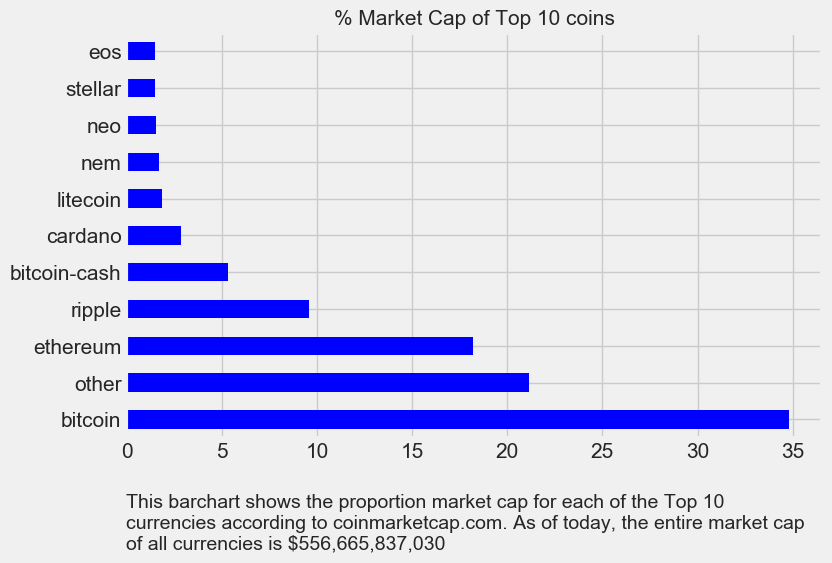

In [32]:
footer = """This barchart shows the proportion market cap for each of the Top 10 
currencies according to coinmarketcap.com. As of today, the entire market cap 
of all currencies is ${}""".format('{0:,.0f}'.format(mc))


top_10 = df_mc[["pct_of_market"]]
top_10 = top_10.sort_values("pct_of_market", ascending = False)
ax = top_10["pct_of_market"].plot.barh(grid = True, fontsize = 15, figsize  = (8,5), stacked="True", colormap='winter')
ax.set(ylabel = "")
#ax.set(xlabel = "Percentage of Market")
ax.set_title("% Market Cap of Top 10 coins",fontsize = 15)
plt.annotate(footer, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

In [15]:
allocation =  [100] * 10
ids = df_mc.index[:10]
port = pd.DataFrame({"start_alloc":allocation, "id":ids}).set_index("id")
port = port.join(df_mc["pct_of_market"])
port["AUM"] = port["start_alloc"].sum()
port["target_alloc"] = (port["pct_of_market"] / 100) * port["AUM"]
port

,start_alloc,pct_of_market,AUM,target_alloc
id,,,,
bitcoin,100,34.814485,1000,348.144851
ethereum,100,18.201548,1000,182.015477
ripple,100,9.598739,1000,95.987388
bitcoin-cash,100,5.346331,1000,53.463308
cardano,100,2.851394,1000,28.513936
litecoin,100,1.864923,1000,18.649233
nem,100,1.726240,1000,17.262403
neo,100,1.524190,1000,15.241900
stellar,100,1.482847,1000,14.828473


In [16]:
for index, row in port.iterrows():
    if row["target_alloc"] > row["start_alloc"]:
        print "BUY: " + str(round(row["target_alloc"] - row["start_alloc"])) + " {}".format(index)
    
    if row["target_alloc"] < row["start_alloc"]:
        print "SELL: " + str(round(row["start_alloc"] - row["target_alloc"])) + " {}".format(index)

BUY: 248.0 bitcoin
BUY: 82.0 ethereum
SELL: 4.0 ripple
SELL: 47.0 bitcoin-cash
SELL: 71.0 cardano
SELL: 81.0 litecoin
SELL: 83.0 nem
SELL: 85.0 neo
SELL: 85.0 stellar
SELL: 85.0 eos
